In [7]:
%%capture --no-stderr
!pip install langgraph langchain-openai langchain-community langchain-core tavily-python wikipedia


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup - STEP 1

In [8]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [10]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "stock-market-analyzer"

In [11]:
_set_env("TAVILY_API_KEY")

## Define analyst - STEP 2

In [12]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class FinancialAnalyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst (e.g., Investment Bank, Hedge Fund).",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst (e.g., Technical Analyst, Fundamental Analyst, Sentiment Analyst).",
    )
    description: str = Field(
        description="Description of the analyst's focus, expertise, and analytical approach.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class AnalystTeam(BaseModel):
    analysts: List[FinancialAnalyst] = Field(
        description="Team of financial analysts with diverse specializations.",
    )

class GenerateAnalystsState(TypedDict):
    stock_symbol: str # Stock symbol to analyze
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[FinancialAnalyst] # Generated analysts

## Analyst Generation System - STEP 3

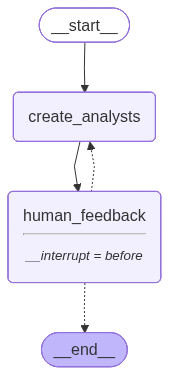

In [13]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class FinancialAnalyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst (e.g., Investment Bank, Hedge Fund).",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst (e.g., Technical Analyst, Fundamental Analyst, Sentiment Analyst).",
    )
    description: str = Field(
        description="Description of the analyst's focus, expertise, and analytical approach.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class AnalystTeam(BaseModel):
    analysts: List[FinancialAnalyst] = Field(
        description="Team of financial analysts with diverse specializations.",
    )

class GenerateAnalystsState(TypedDict):
    stock_symbol: str # Stock symbol to analyze
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[FinancialAnalyst] # Generated analysts
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a team of specialized financial analysts. Follow these instructions:

1. Review the stock symbol:
{stock_symbol}

2. Examine any editorial feedback for analyst creation:

{human_analyst_feedback}

3. Determine the most important analytical perspectives for comprehensive stock analysis.

4. Pick the top {max_analysts} perspectives.

5. Assign one analyst to each perspective with relevant expertise:
   - Technical Analysis (charts, patterns, indicators)
   - Fundamental Analysis (financials, valuations, earnings)
   - Sentiment Analysis (news, social media, market psychology)
   - Macro Analysis (economy, sector trends, regulations)"""

def create_analysts(state: GenerateAnalystsState):
    """ Create financial analysts """

    stock_symbol=state['stock_symbol']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(AnalystTeam)

    system_message = analyst_instructions.format(stock_symbol=stock_symbol,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the analyst team.")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node for interruption """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

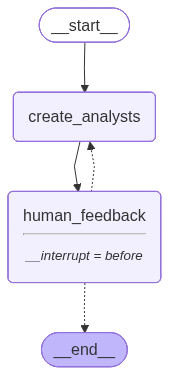

In [14]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a team of specialized financial analysts. Follow these instructions:

1. Review the stock symbol:
{stock_symbol}

2. Examine any editorial feedback for analyst creation:

{human_analyst_feedback}

3. Determine the most important analytical perspectives for comprehensive stock analysis.

4. Pick the top {max_analysts} perspectives.

5. Assign one analyst to each perspective with relevant expertise:
   - Technical Analysis (charts, patterns, indicators)
   - Fundamental Analysis (financials, valuations, earnings)
   - Sentiment Analysis (news, social media, market psychology)
   - Macro Analysis (economy, sector trends, regulations)"""

def create_analysts(state: GenerateAnalystsState):
    """ Create financial analysts """

    stock_symbol=state['stock_symbol']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(AnalystTeam)

    system_message = analyst_instructions.format(stock_symbol=stock_symbol,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the analyst team.")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node for interruption """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
# Input
max_analysts = 3
stock_symbol = "TSLA"
thread = {"configurable": {"thread_id": "1"}}

# Generate analysts
for event in graph.stream({"stock_symbol":stock_symbol,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alex Johnson
Affiliation: Hedge Fund
Role: Technical Analyst
Description: Alex specializes in technical analysis with a focus on chart patterns, moving averages, and momentum indicators. He uses these tools to identify potential entry and exit points for TSLA, leveraging historical price data to forecast future movements.
--------------------------------------------------
Name: Emily Chen
Affiliation: Investment Bank
Role: Fundamental Analyst
Description: Emily is an expert in fundamental analysis, focusing on Tesla's financial statements, valuation metrics, and earnings reports. She evaluates the company's financial health, growth prospects, and intrinsic value to provide long-term investment insights.
--------------------------------------------------
Name: Michael Lee
Affiliation: Market Research Firm
Role: Sentiment Analyst
Description: Michael analyzes market sentiment by monitoring news, social media, and investor forums. He assesses the psychological factors and public per

In [16]:
state = graph.get_state(thread)
state.next


('human_feedback',)

In [17]:
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cf008-a820-66e5-8002-70d8bdca7ac2'}}

In [18]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [21]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
analysts

[FinancialAnalyst(affiliation='Hedge Fund', name='Alex Johnson', role='Technical Analyst', description='Alex specializes in technical analysis with a focus on chart patterns, moving averages, and momentum indicators. He uses these tools to identify potential entry and exit points for TSLA, leveraging historical price data to forecast future movements.'),
 FinancialAnalyst(affiliation='Investment Bank', name='Emily Chen', role='Fundamental Analyst', description="Emily is an expert in fundamental analysis, focusing on Tesla's financial statements, valuation metrics, and earnings reports. She evaluates the company's financial health, growth prospects, and intrinsic value to provide long-term investment insights."),
 FinancialAnalyst(affiliation='Market Research Firm', name='Michael Lee', role='Sentiment Analyst', description="Michael analyzes market sentiment by monitoring news, social media, and investor forums. He assesses the psychological factors and public perception that influence T